# Loading the fish tracking dataset into mmdetection model for training.
This notebook loads the dataset into the mmdetection model and can be used a baseline for further work. The notebook uses the middle data format, which is a easier format than coco format and trains a detection model, faster rcnn in this case.

The notebook has the following outline
- Dataloader
- Model definition and config
- Training
- Visual validation
- TODO: Add evaluation

requirements for this notebook are
- installation of pytorch and mmdetection
- Running the dataparsing notebook

We first import packages and check versioning.

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from progressbar import progressbar

import cv2
import matplotlib.pyplot as plt

1.10.2+cu113 True
2.21.0
11.3
GCC 7.3


## Dataloader

To load the data we define a custom loader. This loader now does the parsing online(before evaluation and starts training). Later on one could looking to offline parsing since it would allow from faster training. The loader consist out of a module registery which contains the dataset parser. The data parser currently only processes one class (predator class) and load the bboxes for that one. There are other variables such as bboxes and labels ignore, which are currently left unused. The dataloader will get called if training starts.

In [2]:
@DATASETS.register_module()
class TrackedFishDataset(CustomDataset):

    CLASSES = ('predator',)

    # TODO: Determine whether the argument is faulty or the method variable.
    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in progressbar(image_list):
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('images', 'labels')

            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[2:6]] for x in content]
            
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

## Defining a model and training scheme.

The config file for training is defined below. It extends on the faster_rcnn config file from coco and adapts the minimum required options. The following points are adapted for the current for training run.

- One should change the num_classes in the head to fit the classes in the dataset loader. 
- The epoch is currently set on 1 for development purposes.

When viewing the output of the config print at the end of the cell, one can see the options. Adapt them if you see fit.

### Data config

In [3]:
from mmcv import Config
from mmdet.apis import set_random_seed


cfg = Config.fromfile('../configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

cfg.dataset_type = 'TrackedFishDataset'
cfg.data_root = '../data/2022_02_10_fish_tracking/'

cfg.data.test.type = 'TrackedFishDataset'
cfg.data.test.data_root = '../data/2022_02_10_fish_tracking/'
cfg.data.test.ann_file = 'test.txt'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'TrackedFishDataset'
cfg.data.train.data_root = '../data/2022_02_10_fish_tracking/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'TrackedFishDataset'
cfg.data.val.data_root = '../data/2022_02_10_fish_tracking/'
cfg.data.val.ann_file = 'test.txt'
cfg.data.val.img_prefix = 'images'


### Model config

In [4]:
# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '../checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../fish_10_epochs'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'

# We can set the evaluation interval to reduce the evaluation times


# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 2

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


cfg.evaluation.interval = 1
cfg.runner.max_epochs = 10
# cfg.resume_from = '../fish_track_exps/epoch_4.pth'
cfg.workflow = [('train', 1)]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

## Training


The following sections trains a model to the config defined above. First the dataset is build, afterwards the detector and then training is started. The mmdetection framework makes it very easy to start training.

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]


# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

100% (7880 of 7880) |####################| Elapsed Time: 0:04:07 Time:  0:04:07
100% (2250 of 2250) |####################| Elapsed Time: 0:01:11 Time:  0:01:11
2022-02-11 17:15:16,928 - mmdet - INFO - load checkpoint from local path: ../checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2022-02-11 17:15:17,059 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bi

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.3 task/s, elapsed: 169s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 17:40:01,997 - mmdet - INFO - 
+----------+------+-------+--------+-------+
| class    | gts  | dets  | recall | ap    |
+----------+------+-------+--------+-------+
| predator | 2250 | 10426 | 0.484  | 0.161 |
+----------+------+-------+--------+-------+
| mAP      |      |       |        | 0.161 |
+----------+------+-------+--------+-------+
2022-02-11 17:40:02,085 - mmdet - INFO - Epoch(val) [1][2250]	AP50: 0.1610, mAP: 0.1612
2022-02-11 17:40:07,548 - mmdet - INFO - Epoch [2][10/3940]	lr: 2.500e-03, eta: 3:17:33, time: 0.528, data_time: 0.225, memory: 3262, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0035, loss_cls: 0.0643, acc: 97.2656, loss_bbox: 0.0908, loss: 0.1601
2022-02-11 17:40:10,550 - mmdet - INFO - Epoch [2][20/3940]	lr: 2.500e-03, eta: 3:17:27, time: 0.301, data_time: 0.021, memory: 3262, loss_rpn_cls: 0.0069, loss_rpn_bbox: 0.0042, loss_cls: 0.0887, acc: 96.9922, loss_bbox: 0.1006, loss: 0.2005
2022-02-11 17:40:13,713 - mmdet - INFO - Epoch [2][30/3940]	lr: 2.500

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.4 task/s, elapsed: 167s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 18:03:54,332 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 5308 | 0.494  | 0.281 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.281 |
+----------+------+------+--------+-------+
2022-02-11 18:03:54,423 - mmdet - INFO - Epoch(val) [2][2250]	AP50: 0.2810, mAP: 0.2815
2022-02-11 18:03:59,866 - mmdet - INFO - Epoch [3][10/3940]	lr: 2.500e-03, eta: 2:52:01, time: 0.526, data_time: 0.226, memory: 3262, loss_rpn_cls: 0.0073, loss_rpn_bbox: 0.0029, loss_cls: 0.0637, acc: 97.6562, loss_bbox: 0.0814, loss: 0.1553
2022-02-11 18:04:02,920 - mmdet - INFO - Epoch [3][20/3940]	lr: 2.500e-03, eta: 2:51:57, time: 0.306, data_time: 0.021, memory: 3262, loss_rpn_cls: 0.0041, loss_rpn_bbox: 0.0034, loss_cls: 0.0531, acc: 97.9199, loss_bbox: 0.0755, loss: 0.1362
2022-02-11 18:04:06,100 - mmdet - INFO - Epoch [3][30/3940]	lr: 2.500e-03, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.5 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 18:27:32,568 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 2062 | 0.298  | 0.206 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.206 |
+----------+------+------+--------+-------+
2022-02-11 18:27:32,655 - mmdet - INFO - Epoch(val) [3][2250]	AP50: 0.2060, mAP: 0.2057
2022-02-11 18:27:38,131 - mmdet - INFO - Epoch [4][10/3940]	lr: 2.500e-03, eta: 2:28:59, time: 0.530, data_time: 0.228, memory: 3262, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0021, loss_cls: 0.0517, acc: 97.8516, loss_bbox: 0.0763, loss: 0.1306
2022-02-11 18:27:41,175 - mmdet - INFO - Epoch [4][20/3940]	lr: 2.500e-03, eta: 2:28:55, time: 0.305, data_time: 0.021, memory: 3262, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0035, loss_cls: 0.0338, acc: 98.7988, loss_bbox: 0.0693, loss: 0.1072
2022-02-11 18:27:44,299 - mmdet - INFO - Epoch [4][30/3940]	lr: 2.500e-03, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.5 task/s, elapsed: 167s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 18:51:13,585 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 6150 | 0.334  | 0.132 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.132 |
+----------+------+------+--------+-------+
2022-02-11 18:51:13,672 - mmdet - INFO - Epoch(val) [4][2250]	AP50: 0.1320, mAP: 0.1324
2022-02-11 18:51:19,064 - mmdet - INFO - Epoch [5][10/3940]	lr: 2.500e-03, eta: 2:07:05, time: 0.522, data_time: 0.225, memory: 3262, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0027, loss_cls: 0.0573, acc: 97.8223, loss_bbox: 0.0715, loss: 0.1331
2022-02-11 18:51:22,096 - mmdet - INFO - Epoch [5][20/3940]	lr: 2.500e-03, eta: 2:07:01, time: 0.303, data_time: 0.021, memory: 3262, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0032, loss_cls: 0.0421, acc: 98.3398, loss_bbox: 0.0610, loss: 0.1071
2022-02-11 18:51:25,308 - mmdet - INFO - Epoch [5][30/3940]	lr: 2.500e-03, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.5 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 19:14:58,003 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 3358 | 0.290  | 0.139 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.139 |
+----------+------+------+--------+-------+
2022-02-11 19:14:58,090 - mmdet - INFO - Epoch(val) [5][2250]	AP50: 0.1390, mAP: 0.1391
2022-02-11 19:15:03,556 - mmdet - INFO - Epoch [6][10/3940]	lr: 2.500e-03, eta: 1:45:40, time: 0.529, data_time: 0.226, memory: 3262, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0021, loss_cls: 0.0283, acc: 98.8965, loss_bbox: 0.0626, loss: 0.0932
2022-02-11 19:15:06,554 - mmdet - INFO - Epoch [6][20/3940]	lr: 2.500e-03, eta: 1:45:36, time: 0.301, data_time: 0.021, memory: 3262, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0028, loss_cls: 0.0339, acc: 98.5938, loss_bbox: 0.0667, loss: 0.1038
2022-02-11 19:15:09,752 - mmdet - INFO - Epoch [6][30/3940]	lr: 2.500e-03, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.5 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 19:38:44,122 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 2308 | 0.360  | 0.255 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.255 |
+----------+------+------+--------+-------+
2022-02-11 19:38:44,212 - mmdet - INFO - Epoch(val) [6][2250]	AP50: 0.2550, mAP: 0.2545
2022-02-11 19:38:49,691 - mmdet - INFO - Epoch [7][10/3940]	lr: 2.500e-03, eta: 1:24:24, time: 0.530, data_time: 0.226, memory: 3262, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0020, loss_cls: 0.0273, acc: 98.9551, loss_bbox: 0.0570, loss: 0.0865
2022-02-11 19:38:52,735 - mmdet - INFO - Epoch [7][20/3940]	lr: 2.500e-03, eta: 1:24:21, time: 0.305, data_time: 0.021, memory: 3262, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0031, loss_cls: 0.0399, acc: 98.1250, loss_bbox: 0.0701, loss: 0.1145
2022-02-11 19:38:55,957 - mmdet - INFO - Epoch [7][30/3940]	lr: 2.500e-03, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.6 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 20:02:24,794 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 2167 | 0.391  | 0.297 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.297 |
+----------+------+------+--------+-------+
2022-02-11 20:02:24,879 - mmdet - INFO - Epoch(val) [7][2250]	AP50: 0.2970, mAP: 0.2974
2022-02-11 20:02:30,249 - mmdet - INFO - Epoch [8][10/3940]	lr: 2.500e-03, eta: 1:03:12, time: 0.520, data_time: 0.225, memory: 3262, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0019, loss_cls: 0.0281, acc: 98.6621, loss_bbox: 0.0471, loss: 0.0773
2022-02-11 20:02:33,300 - mmdet - INFO - Epoch [8][20/3940]	lr: 2.500e-03, eta: 1:03:09, time: 0.305, data_time: 0.021, memory: 3262, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0027, loss_cls: 0.0320, acc: 98.6816, loss_bbox: 0.0607, loss: 0.0956
2022-02-11 20:02:36,528 - mmdet - INFO - Epoch [8][30/3940]	lr: 2.500e-03, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.3 task/s, elapsed: 169s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 20:27:13,875 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 1252 | 0.199  | 0.134 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.134 |
+----------+------+------+--------+-------+
2022-02-11 20:27:13,963 - mmdet - INFO - Epoch(val) [8][2250]	AP50: 0.1340, mAP: 0.1340
2022-02-11 20:27:19,561 - mmdet - INFO - Epoch [9][10/3940]	lr: 2.500e-04, eta: 0:42:20, time: 0.542, data_time: 0.226, memory: 3262, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0019, loss_cls: 0.0294, acc: 98.7988, loss_bbox: 0.0581, loss: 0.0897
2022-02-11 20:27:22,725 - mmdet - INFO - Epoch [9][20/3940]	lr: 2.500e-04, eta: 0:42:17, time: 0.317, data_time: 0.022, memory: 3262, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0026, loss_cls: 0.0348, acc: 98.4277, loss_bbox: 0.0595, loss: 0.0974
2022-02-11 20:27:25,975 - mmdet - INFO - Epoch [9][30/3940]	lr: 2.500e-04, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.5 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 20:51:16,464 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 2005 | 0.360  | 0.276 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.276 |
+----------+------+------+--------+-------+
2022-02-11 20:51:16,552 - mmdet - INFO - Epoch(val) [9][2250]	AP50: 0.2760, mAP: 0.2759
2022-02-11 20:51:21,981 - mmdet - INFO - Epoch [10][10/3940]	lr: 2.500e-04, eta: 0:21:09, time: 0.526, data_time: 0.226, memory: 3262, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0015, loss_cls: 0.0189, acc: 99.2285, loss_bbox: 0.0385, loss: 0.0589
2022-02-11 20:51:25,082 - mmdet - INFO - Epoch [10][20/3940]	lr: 2.500e-04, eta: 0:21:05, time: 0.310, data_time: 0.021, memory: 3262, loss_rpn_cls: 0.0000, loss_rpn_bbox: 0.0021, loss_cls: 0.0190, acc: 99.2090, loss_bbox: 0.0435, loss: 0.0646
2022-02-11 20:51:28,314 - mmdet - INFO - Epoch [10][30/3940]	lr: 2.500e-04

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2250/2250, 13.5 task/s, elapsed: 167s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-11 21:15:08,838 - mmdet - INFO - 
+----------+------+------+--------+-------+
| class    | gts  | dets | recall | ap    |
+----------+------+------+--------+-------+
| predator | 2250 | 1606 | 0.336  | 0.274 |
+----------+------+------+--------+-------+
| mAP      |      |      |        | 0.274 |
+----------+------+------+--------+-------+
2022-02-11 21:15:08,928 - mmdet - INFO - Epoch(val) [10][2250]	AP50: 0.2740, mAP: 0.2742


## Visual validation.

The model has been trained and has created checkpoint files in the checkpoint directory. We can use these checkpoints to visually validate whether our model does the correct predictions. 


In [6]:
from mmdet.apis import inference_detector, init_detector

def visualise_img(img_name, data_dir, checkpoint, config):
    """ Visualizes an image with bboxes and groundtruth. 

    Args:
        img_name (str): The name of the file wihtou ext
        data_dir (str): The location of the data
        checkpoint (str): checkpoint location of the model
        config (dict): configuration dict specifing the model
    """
    print(data_dir)
    img = mmcv.imread(f'{data_dir}/images/{img_name}.jpg')
    label_file = f"{data_dir}/labels/{img_name}.txt"

    with open(label_file) as f:
        gt = f.readlines()[0]

    label = gt.split(" ")[2:6]
    label = label + [1.0]
    
    # initialize the detector
    model = init_detector(config, checkpoint, device='cuda:0')

    # model.cfg = cfg
    result = inference_detector(model, img)

    img = plot_bbox(img, [label], color=(36,12,255))
    
    img = plot_bbox(img, result[0])

    plt.figure(figsize=(25, 20))
    plt.imshow(mmcv.bgr2rgb(img))
    plt.show()


def plot_bbox(img, bboxes, color=(36,255,12), thickness = 4):
    """Plots the bounding boxes onto an image. Only plots boxes with confinces higher than 0.5.
    TODO: add nms.

    Args:
        img (np.array): The image.
        bboxes ([type]): bounding boxes to be plotted
        color (tuple, optional): The color of the bounding boxes. Defaults to (36,255,12).
        thickness (int, optional): Thinkness of the bounding box. Defaults to 4.

    Returns:
        img (np.array): The image with bounding boxes draw upon. Returned to be used further.
    """
    for bbox in bboxes:
        conf = bbox[4]
        if conf <= 0.5:
            break
        xmin = int(bbox[0])
        ymin = int(bbox[1])
        xmax = int(bbox[2])
        ymax = int(bbox[3]) 
        conf = str("{:.2f}".format(bbox[4]))
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
        cv2.putText(img, conf, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, thickness)

    return img


../data/2022_02_10_fish_tracking
load checkpoint from local path: ../fish_10_epochs/latest.pth


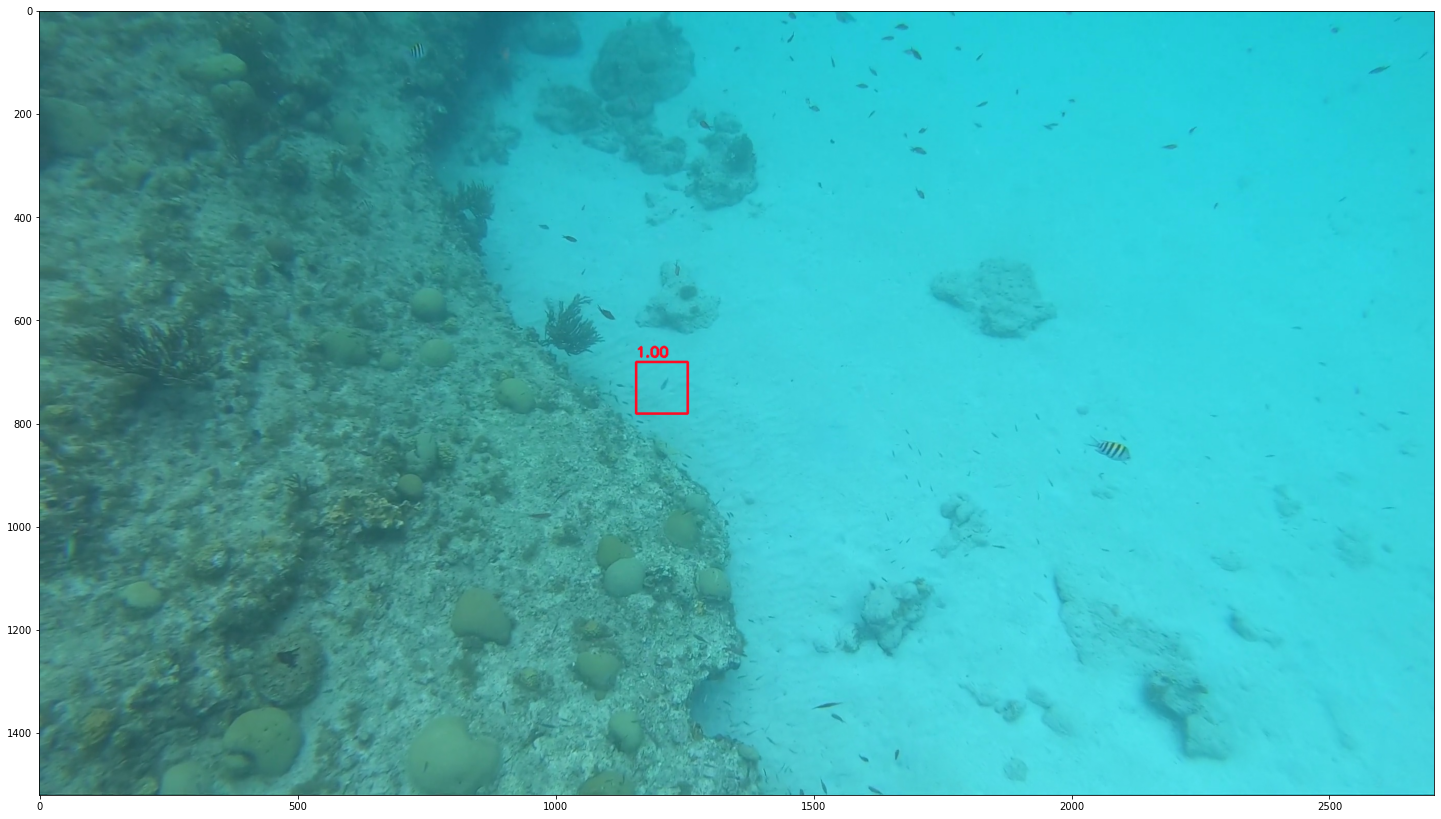

In [23]:
img_name = "144_A_00125"
img_name = "160_A_00034" # Bad
# img_name = "442_C_00155" # Bad 
# img_name = "455_A_00015" # Good
img_name = "455_B_00070"
img_name = "455_B_00076"
img_name = "457_A_00040"
img_name = "457_B_00017"
img_name = "469_B_00050"
img_name = "469_C_00077"
img_name = "469_C_00100"
# Setup a checkpoint file to load
checkpoint = '../fish_10_epochs/latest.pth'
data_dir = '../data/2022_02_10_fish_tracking'
visualise_img(img_name, data_dir, checkpoint, cfg)

## Evaluation